<h1 align="center">Time Series</h1>
<h3 align="center">Dataset: <a href="https://www.kaggle.com/c/competitive-data-science-predict-future-sales">Competitive data science: Predict future sales</a></h3>

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics       import mean_squared_error
import lightgbm as lgb

import gc
import time

from ipywidgets import interact

In [2]:
!ls ../../datasets/predict-future-sales

item_categories.csv  sales_train.csv	    shops.csv
items.csv	     sample_submission.csv  test.csv


## Daily sales between January 2013 until Octuber 2015.

In [3]:
path = "../../datasets/predict-future-sales/"

t = time.time()
train = pd.read_csv(path+"sales_train.csv") # Daily sales  Jan 2013 -> Oct 2015
shops = pd.read_csv(path+"shops.csv")       # Shops    (60)
items = pd.read_csv(path+"items.csv")       # Products  (22170)
cats  = pd.read_csv(path+"item_categories.csv") # Product categories (84)
test  = pd.read_csv(path+"test.csv", index_col="ID") # predict November 2015
sub   = pd.read_csv(path+"sample_submission.csv", index_col="ID")
print(round(time.time() - t,2), "secs")

0.92 secs


In [4]:
sub.item_cnt_month = 99
sub

,item_cnt_month
ID,
0,99
1,99
2,99
3,99
4,99
...,...
214195,99
214196,99
214197,99


In [5]:
train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


In [6]:
train.tail(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


# Objetive: sales of November 2015

In [7]:
test.head()

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


# EDA

### Outlier: Sales with a lot of quatities

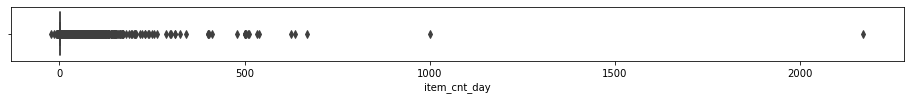

In [8]:
plt.figure(figsize=(16,1))
sb.boxplot(x=train.item_cnt_day);

### Outlier: Sales with a expensive items

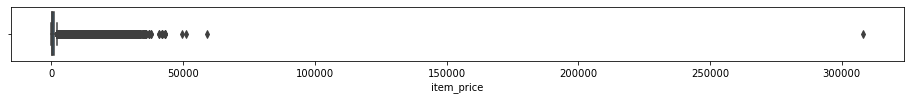

In [9]:
plt.figure(figsize=(16,1))
sb.boxplot(x=train.item_price);

### Negative prices -> Refunds

In [10]:
train.loc[train.item_price<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


---

# Get only sales of october 2015 

In [11]:
oct2015 = train[train.date_block_num==33]
oct2015

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2882335,23.10.2015,33,45,13315,649.0,1.0
2882336,05.10.2015,33,45,13880,229.0,1.0
2882337,02.10.2015,33,45,13881,659.0,1.0
2882338,12.10.2015,33,45,13881,659.0,1.0
2882339,04.10.2015,33,45,13923,169.0,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0


In [12]:
oct2015.shop_id.nunique() # There are 44 of 60 shops on this month

44

In [13]:
oct2015.item_id.nunique() # There ar 5413 of 22170 items on this month

5413

In [14]:
oct2015.groupby(["shop_id", "item_id"])[["item_cnt_day"]].agg(["min", "max", "mean", "count", "sum"])

item_cnt_day                     
                         min  max mean count  sum
shop_id item_id                                  
2       31               1.0  1.0  1.0     1  1.0
        486              1.0  1.0  1.0     3  3.0
        787              1.0  1.0  1.0     1  1.0
        794              1.0  1.0  1.0     1  1.0
        968              1.0  1.0  1.0     1  1.0
...                      ...  ...  ...   ...  ...
59      22087            1.0  3.0  2.0     3  6.0
        22088            1.0  1.0  1.0     2  2.0
        22091            1.0  1.0  1.0     1  1.0
        22100            1.0  1.0  1.0     1  1.0
        22102            1.0  1.0  1.0     1  1.0

[31531 rows x 5 columns]

In [15]:
oct2015_agg = oct2015.groupby(["shop_id", "item_id"])["item_cnt_day"].sum().reset_index()
oct2015_agg

,shop_id,item_id,item_cnt_day
0,2,31,1.0
1,2,486,3.0
2,2,787,1.0
3,2,794,1.0
4,2,968,1.0
...,...,...,...
31526,59,22087,6.0
31527,59,22088,2.0
31528,59,22091,1.0
31529,59,22100,1.0


In [16]:
test

,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268
...,...,...
214195,45,18454
214196,45,16188
214197,45,15757


In [17]:
sub.head()

,item_cnt_month
ID,
0,99
1,99
2,99
3,99
4,99


In [18]:
results = pd.merge(left = test,         # Left table for the join
                   right = oct2015_agg, # Right table for the join
                   on=["shop_id", "item_id"], # Common keys
                   how='left')          # Type of join

results.head()

,shop_id,item_id,item_cnt_day
0,5,5037,NaN
1,5,5320,NaN
2,5,5233,1.0
3,5,5232,NaN
4,5,5268,NaN


In [19]:
print("% of missings:", results.item_cnt_day.isna().sum() / len(results) * 100)

% of missings: 86.61064425770309


### Fill missings with ceros

In [20]:
results.item_cnt_day = results.item_cnt_day.fillna(0)
results.head()

,shop_id,item_id,item_cnt_day
0,5,5037,0.0
1,5,5320,0.0
2,5,5233,1.0
3,5,5232,0.0
4,5,5268,0.0


### Clipping (limit) mins and max values

In [21]:
results.item_cnt_day = results.item_cnt_day.clip(lower=0, upper=20)
results.head()

,shop_id,item_id,item_cnt_day
0,5,5037,0.0
1,5,5320,0.0
2,5,5233,1.0
3,5,5232,0.0
4,5,5268,0.0


In [22]:
sub["item_cnt_month"] = results["item_cnt_day"]
sub.head()

,item_cnt_month
ID,
0,0.0
1,0.0
2,1.0
3,0.0
4,0.0


In [23]:
sub.to_csv("oct2015.csv")

In [24]:
!head oct2015.csv

ID,item_cnt_month
0,0.0
1,0.0
2,1.0
3,0.0
4,0.0
5,1.0
6,2.0
7,0.0
8,0.0
